# Air Quality Prediction Experiment

This notebook combines PWWB, AirNow, and HRRR datasets for air quality prediction using TF-Keras.

# Experiment Configuration

In [1]:
# ========== EXPERIMENT CONFIGURATION ==========
# Change these variables to configure your experiment

EXPERIMENT_NAME = "December 2022 to December 2024"
EXPERIMENT_DESCRIPTION = "2023-2024 period with PWWB, HRRR, and Airnow data."
EXPERIMENT_ID = "two_years_pwwb_airnow_hrrr"

# Data parameters
START_DATE = "2022-12-01-00"
END_DATE = "2024-12-01-00"
TRAIN_SPLIT = 0.70  # 70% for training, 10% for val (will split later), leaving 20% for test.

# Model parameters
EPOCHS = 100
BATCH_SIZE = 16
WEIGHT_DECAY = 0.01

print(f"Experiment: {EXPERIMENT_NAME}")
print(f"Description: {EXPERIMENT_DESCRIPTION}")
print(f"Date Range: {START_DATE} to {END_DATE}")
print(f"Train/Test Split: {TRAIN_SPLIT*100:.0f}%/{(1-TRAIN_SPLIT)*100:.0f}% (temporal)")

Experiment: December 2022 to December 2024
Description: 2023-2024 period with PWWB, HRRR, and Airnow data.
Date Range: 2022-12-01-00 to 2024-12-01-00
Train/Test Split: 70%/30% (temporal)


# Data Parameters

In [2]:
# Define bounding box
lat_bottom, lat_top = 33.5, 34.5
lon_bottom, lon_top = -118.75, -117.0
extent = (lon_bottom, lon_top, lat_bottom, lat_top)

# Input data shape
dim = 40
frames_per_sample = 5

print(f"{extent}")
print(f"Grid dimension: {dim}x{dim}")
print(f"Frames per sample: {frames_per_sample}")

(-118.75, -117.0, 33.5, 34.5)
Grid dimension: 40x40
Frames per sample: 5


# Data Ingestion and Preprocessing

In [3]:
# Python nonsense that allows you to import from sibling directories
import sys
sys.path.append("../..")

import pandas as pd
from dotenv import load_dotenv

# Import the new PWWB implementation and dataset manager
from libs.pwwb import PWWBData
from libs.pwwb.utils.dataset_manager import create_dataset_manager

# Import the AirNow data class
from libs.airnowdata import AirNowData
from libs.hrrrdata import HRRRData

# Load environment variables (API keys, credentials)
load_dotenv()

import numpy as np
# Temporal train-test split function
def temporal_train_test_split(X, Y, train_size=0.8):
    """Split data temporally - first portion for training, last portion for testing"""
    split_idx = int(X.shape[0] * train_size)
    
    X_train = X[:split_idx]
    X_test = X[split_idx:]
    Y_train = Y[:split_idx]
    Y_test = Y[split_idx:]
    
    print(f"Temporal split at index {split_idx}:")
    print(f"  Training: samples 0-{split_idx-1} ({train_size*100:.0f}% of time)")
    print(f"  Testing: samples {split_idx}-{len(X)-1} ({(1-train_size)*100:.0f}% of time)")
    
    return X_train, X_test, Y_train, Y_test
    
def temporal_train_test_valid_split(X, Y, train_size=0.7, test_size=0.2, valid_size=0.1):
    train_split = int(X.shape[0] * train_size)
    test_split = int(X.shape[0] * (train_size + valid_size))
    
    X_train = X[:train_split]
    X_valid = X[train_split:test_split]
    X_test = X[test_split:]
    Y_train = Y[:train_split]
    Y_valid = Y[train_split:test_split]
    Y_test = Y[test_split:]
    
    print(f"Temporal split at indices {train_split} and {test_split}:")
    print(f"  Training: samples 0-{train_split-1} ({train_size*100:.0f}% of time)")
    print(f"  Validation: samples {train_split}-{test_split-1} ({valid_size*100:.0f}% of time)")
    print(f"  Testing: samples {test_split}-{len(X)-1} ({test_size*100:.0f}% of time)")
    
    return X_train, X_test, X_valid, Y_train, Y_test, Y_valid

# scale training data, then scale test data based on training data stats
from sklearn.preprocessing import StandardScaler
def std_scale(X_train, X_test):
    scaler = StandardScaler()
    scaled_train = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
    scaled_test = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

    return scaled_train, scaled_test

import joblib
def std_scale_train_test_valid(X_train, X_test, X_valid, save=False, save_path='data'):
    scaler = StandardScaler()
    scaled_train = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
    scaled_test = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)
    scaled_valid = scaler.transform(X_valid.reshape(-1, 1)).reshape(X_valid.shape)

    if save:
        joblib.dump(scaler, save_path, compress=True)

    return scaled_train, scaled_test, scaled_valid

/home/mgraca/miniconda3/envs/hrrrenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
from datetime import datetime

# Create output directory for results
output_dir = f"experiment_output/{EXPERIMENT_ID}"
os.makedirs(output_dir, exist_ok=True)

# Create dataset manager
manager = create_dataset_manager(
    registry_file=f"{EXPERIMENT_ID}_registry.json",
    cache_dir="data/two_years_with_hrrr/pwwb_cache/"
)

# List existing datasets
print("Existing datasets:")
try:
    display(manager.list_datasets())
except:
    print("No existing datasets found.")

Existing datasets:


,name,created,description,start_date,end_date,channels
0,two_years_pwwb_airnow_hrrr_MAIAC_TROPOMI_NO2_M...,2025-07-16T13:54:46.665180,"2023-2024 period with PWWB, HRRR, and Airnow d...",2022-12-01-00,2024-12-01-00,"maiac, tropomi, metar"
1,two_years_pwwb_airnow_hrrr_METAR_WIND_UV,2025-07-25T12:11:18.851860,"2023-2024 period with PWWB, HRRR, and Airnow d...",2022-12-01-00,2024-12-01-00,metar


In [5]:
# Adjust end date for AirNow
end_date_adj = pd.to_datetime(END_DATE) - pd.Timedelta(hours=1)

# Dataset name and description
dataset_name = f"{EXPERIMENT_ID}_METAR_WIND_UV"
dataset_desc = f"{EXPERIMENT_DESCRIPTION} - METAR Wind U/V components"

# ========== 1. Load PWWB Data ==========
print(f"\nLoading PWWB data for {EXPERIMENT_NAME}...")

# Check if dataset already exists in the registry
if manager.get_dataset_info(dataset_name) is not None:
    print(f"Dataset '{dataset_name}' already exists, loading from cache...")
    pwwb_data = manager.load_dataset(dataset_name, PWWBData)
else:
    print(f"Dataset '{dataset_name}' not found, creating new one...")
    # Create the dataset with the specified channels
    pwwb_data = manager.create_dataset(
        name=dataset_name,
        description=dataset_desc,
        PWWBData_class=PWWBData,
        start_date=START_DATE,
        end_date=END_DATE,
        extent=extent,
        frames_per_sample=frames_per_sample,
        dim=dim,
        include_channels={
            'maiac': False,                     # Include MAIAC AOD
            'tropomi': False,        # Only include NO2 from TROPOMI
            'metar': ['METAR_Wind_U', 'METAR_Wind_V'],  # Only wind components from METAR
            'modis_fire': False,               # Exclude MODIS fire data
            'merra2': False                    # Exclude MERRA2 data
        },
        verbose=True,
        output_dir=output_dir
    )
    # Save the dataset
    pwwb_data.save_data()

# Get the data and channel info
X_pwwb = pwwb_data.data
channel_info = pwwb_data.get_channel_info()
print(f"✓ PWWB data shape: {X_pwwb.shape}")
print(f"  Channels: {channel_info['channel_names']}")

# ========== 2. Load AirNow Data ==========
print(f"\nLoading AirNow data for {EXPERIMENT_NAME}...")
airnow_data = AirNowData(
    start_date=START_DATE,
    end_date=end_date_adj,
    extent=extent,
    airnow_api_key=os.getenv('AIRNOW_API_KEY'),
    save_dir='data/two_years_with_hrrr/airnow_cache/airnow.json',
    processed_cache_dir='data/two_years_with_hrrr/airnow_cache/airnow_processed.npz',
    frames_per_sample=frames_per_sample,
    dim=dim,
    elevation_path="../../libs/inputs/elevation.npy",
    mask_path="../../libs/inputs/mask.npy",
    use_mask=False,
    force_reprocess=False
)
X_airnow = airnow_data.data
Y_targets = airnow_data.target_stations
print(f"✓ AirNow data shape: {X_airnow.shape}")
if Y_targets is not None:
    print(f"  Target stations shape: {Y_targets.shape}")
    print(f"  Number of sensors: {len(airnow_data.air_sens_loc)}")
    print(f"  Sensor names: {airnow_data.sensor_names}")
else:
    print("  No target stations available")

#========== 3. Load HRRR Data ==========
'''
print(f"\nLoading HRRR data for {EXPERIMENT_NAME}...")
hrrr_data = HRRRData(
    start_date=START_DATE,
    end_date=END_DATE,
    extent=extent,
    extent_name='la_region',
    product='COLMD',
    frames_per_sample=frames_per_sample,
    dim=dim,
    verbose=True,
    processed_cache_dir='data/two_years_with_hrrr/hrrr_cache/hrrr_processed.npz',
    chunk_cache_dir='data/two_years_with_hrrr/hrrr_cache/hrrr_chunks',
    sample_setting=2
)
X_hrrr = hrrr_data.data
print(f"✓ HRRR data shape: {X_hrrr.shape}")
''';


Loading PWWB data for December 2022 to December 2024...
Dataset 'two_years_pwwb_airnow_hrrr_METAR_WIND_UV' already exists, loading from cache...
Using cache prefix: two_years_pwwb_airnow_hrrr_METAR_WIND_UV_
Initialized PWWBData with 17544 hourly timestamps
Date range: 2022-12-01 00:00:00 to 2024-11-30 23:00:00
Channels included: ['metar']
METAR channels: ['METAR_Wind_U', 'METAR_Wind_V']
Processing METAR meteorological data...
Elevation data not found at ../inputs/elevation.npy. Using flat elevation.
Initialized MetarDataSource with 2 channels: ['METAR_Wind_U', 'METAR_Wind_V']
Will fetch these raw variables: ['sped', 'drct']
Will calculate wind U/V components from speed/direction
Loading cached data from data/two_years_with_hrrr/pwwb_cache/two_years_pwwb_airnow_hrrr_METAR_WIND_UV_metar_u_v_data.npy
Final data shape: (17540, 5, 40, 40, 2)

Channel Statistics:

Channel 0: METAR_Wind_U
  Min: 3.4740779667173873
  Max: 4.433922992082574
  Mean: 3.9388995343038595
  Std: 0.181296835244206
 

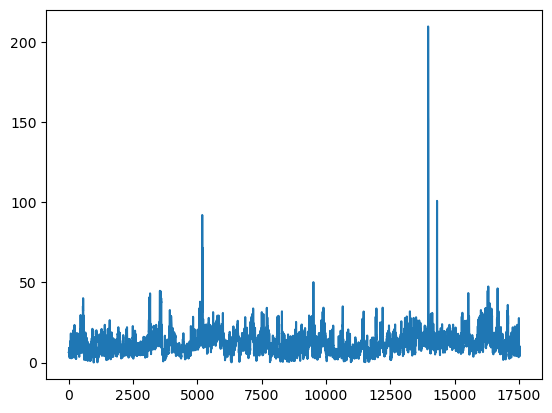

In [6]:
import matplotlib.pyplot as plt
plt.plot(Y_targets[:,0,4])

In [24]:
np.where(Y_targets == 0)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [7]:
del airnow_data
del pwwb_data
#del hrrr_data

# ========== 4. Create Combined Dataset ==========
print(f"\nCreating combined dataset for {EXPERIMENT_NAME}...")

# First, check shapes and find minimum timesteps
print(f"Data shapes before combining:")
print(f"  PWWB: {X_pwwb.shape}")
print(f"  AirNow: {X_airnow.shape}")
#print(f"  HRRR: {X_hrrr.shape}")
print(f"  Targets: {Y_targets.shape}")

# Find the minimum number of timesteps across all datasets
min_timesteps = min(X_pwwb.shape[0], X_airnow.shape[0], Y_targets.shape[0])
print(f"Minimum timesteps across all datasets: {min_timesteps}")

# Trim all datasets to the same number of timesteps
X_pwwb = X_pwwb[:min_timesteps]
X_airnow = X_airnow[:min_timesteps]
#X_hrrr = X_hrrr[:min_timesteps]
Y_targets = Y_targets[:min_timesteps]  # Don't forget to trim Y_targets too!

print(f"Data shapes after trimming:")
print(f"  PWWB: {X_pwwb.shape}")
print(f"  AirNow: {X_airnow.shape}")
#print(f"  HRRR: {X_hrrr.shape}")
print(f"  Y_targets: {Y_targets.shape}")

# Combine all data sources
X_combined = np.concatenate([X_pwwb, X_airnow], axis=-1)
print(f"Combined data shape: {X_combined.shape}")

# Display the number of channels from each source
pwwb_channels = X_pwwb.shape[4]
airnow_channels = X_airnow.shape[4]
#hrrr_channels = X_hrrr.shape[4]
total_channels = X_combined.shape[4]

print(f"Channel breakdown:")
print(f"  PWWB: {pwwb_channels} channels")
print(f"  AirNow: {airnow_channels} channels")
#print(f"  HRRR: {hrrr_channels} channels")
print(f"  Total: {total_channels} channels")

# Create combined channel names
all_channel_names = channel_info['channel_names'] + ["AirNow_PM25"]
print(f"  Channel names: {all_channel_names}")


Creating combined dataset for December 2022 to December 2024...
Data shapes before combining:
  PWWB: (17540, 5, 40, 40, 2)
  AirNow: (17540, 5, 40, 40, 1)
  Targets: (17535, 5, 16)
Minimum timesteps across all datasets: 17535
Data shapes after trimming:
  PWWB: (17535, 5, 40, 40, 2)
  AirNow: (17535, 5, 40, 40, 1)
  Y_targets: (17535, 5, 16)
Combined data shape: (17535, 5, 40, 40, 3)
Channel breakdown:
  PWWB: 2 channels
  AirNow: 1 channels
  Total: 3 channels
  Channel names: ['METAR_Wind_U', 'METAR_Wind_V', 'AirNow_PM25']


In [8]:
del X_pwwb
del X_airnow
#del X_hrrr

print(f"\nCreating temporal train/test split for {EXPERIMENT_NAME}...")
save_path = "final_input_data/two_years_with_hrrr/"

for i, c in enumerate(all_channel_names):
    X_train, X_test, X_valid, Y_train, Y_test, Y_valid = temporal_train_test_valid_split(
        X_combined[:,:,:,:,i], Y_targets, train_size=0.7, test_size=0.15, valid_size=0.15
    )
    
    print(f"✓ Train shapes: X={X_train.shape}, Y={Y_train.shape}")
    print(f"✓ Test shapes: X={X_test.shape}, Y={Y_test.shape}")
    print(f"✓ Valid shapes: X={X_valid.shape}, Y={Y_valid.shape}")
    
    # ========== 6. Standardize Data ==========
    X_train_scaled, X_test_scaled, X_valid_scaled = std_scale_train_test_valid(
        X_train, X_test, X_valid, True, f'data/two_years_with_hrrr/scalers/{c}_std_scaler.bin'
    )
    print(f"✓ Scaled train shape: {X_train_scaled.shape}")
    print(f"✓ Scaled test shape: {X_test_scaled.shape}")
    print(f"✓ Scaled valid shape: {X_valid_scaled.shape}")

    np.save(f"{save_path}{all_channel_names[i]}_X_train.npy", X_train_scaled)
    np.save(f"{save_path}{all_channel_names[i]}_X_test.npy", X_test_scaled)
    np.save(f"{save_path}{all_channel_names[i]}_X_valid.npy", X_valid_scaled)

    print(f"Saved {all_channel_names[i]} data.\n")
    
print(f"Y_train range: {Y_train.min():.2f} to {Y_train.max():.2f}")
print(f"Y_train mean: {Y_train.mean():.2f}, std: {Y_train.std():.2f}")
np.save(f"{save_path}Y_train.npy", Y_train)
np.save(f"{save_path}Y_test.npy", Y_test)
np.save(f"{save_path}Y_valid.npy", Y_valid)


Creating temporal train/test split for December 2022 to December 2024...
Temporal split at indices 12274 and 14904:
  Training: samples 0-12273 (70% of time)
  Validation: samples 12274-14903 (15% of time)
  Testing: samples 14904-17534 (15% of time)
✓ Train shapes: X=(12274, 5, 40, 40), Y=(12274, 5, 16)
✓ Test shapes: X=(2631, 5, 40, 40), Y=(2631, 5, 16)
✓ Valid shapes: X=(2630, 5, 40, 40), Y=(2630, 5, 16)
✓ Scaled train shape: (12274, 5, 40, 40)
✓ Scaled test shape: (2631, 5, 40, 40)
✓ Scaled valid shape: (2630, 5, 40, 40)
Saved METAR_Wind_U data.

Temporal split at indices 12274 and 14904:
  Training: samples 0-12273 (70% of time)
  Validation: samples 12274-14903 (15% of time)
  Testing: samples 14904-17534 (15% of time)
✓ Train shapes: X=(12274, 5, 40, 40), Y=(12274, 5, 16)
✓ Test shapes: X=(2631, 5, 40, 40), Y=(2631, 5, 16)
✓ Valid shapes: X=(2630, 5, 40, 40), Y=(2630, 5, 16)
✓ Scaled train shape: (12274, 5, 40, 40)
✓ Scaled test shape: (2631, 5, 40, 40)
✓ Scaled valid shape: (2

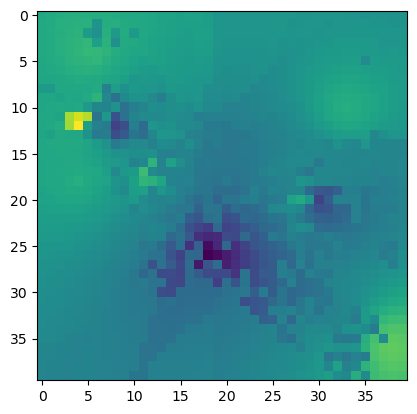

In [9]:
import matplotlib.pyplot as plt
plt.imshow(np.load("final_input_data/two_years_with_hrrr/AirNow_PM25_X_train.npy")[0,1,:,:])

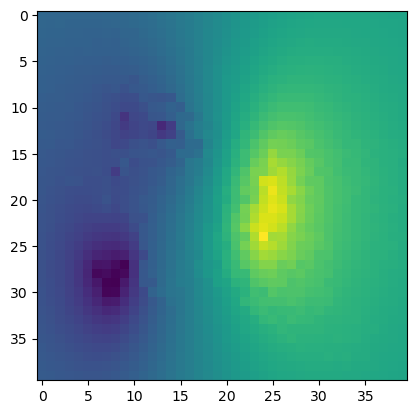

In [10]:
plt.imshow(np.load("final_input_data/two_years_with_hrrr/METAR_Wind_U_X_train.npy")[0,1,:,:])

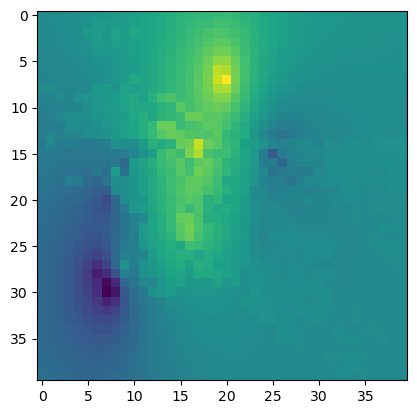

In [11]:
plt.imshow(np.load("final_input_data/two_years_with_hrrr/METAR_Wind_V_X_train.npy")[0,1,:,:])

# Timestep encoding

In [12]:
import pandas as pd
dates = pd.date_range(start=START_DATE, end=END_DATE, freq='h')

In [13]:
print(
    dates[0], '\n',
    "Month:", dates.strftime('%B').unique().astype('string'), '\n',
    "Day of Week:", dates.strftime('%A').unique().astype('string'), '\n',
    "Hour:", dates.strftime('%-H').unique().astype('int'), '\n',
)

2022-12-01 00:00:00 
 Month: Index(['December', 'January', 'February', 'March', 'April', 'May', 'June',
       'July', 'August', 'September', 'October', 'November'],
      dtype='string') 
 Day of Week: Index(['Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday',
       'Wednesday'],
      dtype='string') 
 Hour: Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23],
      dtype='int64') 



In [14]:
len(dates)

17545

In [15]:
pd.get_dummies(dates.strftime('%B'), dtype='float')

,April,August,December,February,January,July,June,March,May,November,October,September
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
17541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
17542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
17543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [16]:
pd.get_dummies(dates.strftime('%A'), dtype='float')

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...
17540,0.0,0.0,1.0,0.0,0.0,0.0,0.0
17541,0.0,0.0,1.0,0.0,0.0,0.0,0.0
17542,0.0,0.0,1.0,0.0,0.0,0.0,0.0
17543,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [17]:
pd.get_dummies(dates.strftime('%-d'), dtype='float')

,1,10,11,12,13,14,15,16,17,18,...,29,3,30,31,4,5,6,7,8,9
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
pd.get_dummies(dates.strftime('%-H'), dtype='float')

,0,1,10,11,12,13,14,15,16,17,...,21,22,23,3,4,5,6,7,8,9
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
temporal_encoded_data = pd.concat(
    [
        pd.get_dummies(dates.strftime('%B'), dtype='float'), 
        pd.get_dummies(dates.strftime('%A'), dtype='float'),
        pd.get_dummies(dates.strftime('%-d'), dtype='float'),
        pd.get_dummies(dates.strftime('%-H'), dtype='float')
    ],
    axis=1
).to_numpy()
print(temporal_encoded_data)
print(temporal_encoded_data.shape)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
(17545, 74)


In [20]:
def sliding_window_of(dates, window_size):
    n_frames, n_categories = dates.shape
    total_samples = n_frames - window_size + 1
    if total_samples <= 0:
        raise ValueError("Not enough samples to support given window size.")

    samples = np.empty((total_samples, window_size, n_categories))

    for i in range(total_samples):
        samples[i] = dates[i : i + window_size]

    return samples

In [21]:
sampled_temporal_data = sliding_window_of(temporal_encoded_data, 5)
print(sampled_temporal_data)
print(sampled_temporal_data.shape)

[[[0. 0. 1. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]]

 [[0. 0. 1. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]]

 [[0. 0. 1. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]]]
(17541, 5, 74)


In [22]:
temporal_encoding_X = sampled_temporal_data[:min_timesteps]
print(temporal_encoding_X)
print(temporal_encoding_X.shape)

[[[0. 0. 1. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]]

 [[0. 0. 1. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]]

 [[0. 0. 1. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
(17535, 5, 74)


In [23]:
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = temporal_train_test_valid_split(
    temporal_encoding_X, Y_targets, train_size=0.7, test_size=0.15, valid_size=0.15
)

print(f"✓ Train shapes: X={X_train.shape}, Y={Y_train.shape}")
print(f"✓ Test shapes: X={X_test.shape}, Y={Y_test.shape}")
print(f"✓ Valid shapes: X={X_valid.shape}, Y={Y_valid.shape}")

np.save(f"{save_path}Temporal_Encoding_X_train.npy", X_train)
np.save(f"{save_path}Temporal_Encoding_X_test.npy", X_test)
np.save(f"{save_path}Temporal_Encoding_X_valid.npy", X_valid)

Temporal split at indices 12274 and 14904:
  Training: samples 0-12273 (70% of time)
  Validation: samples 12274-14903 (15% of time)
  Testing: samples 14904-17534 (15% of time)
✓ Train shapes: X=(12274, 5, 74), Y=(12274, 5, 16)
✓ Test shapes: X=(2631, 5, 74), Y=(2631, 5, 16)
✓ Valid shapes: X=(2630, 5, 74), Y=(2630, 5, 16)
